# Step 4: Reconstruction

## a) Reconstruct

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 30]
energies = [200, 600, 1000]
erels = [100, 500]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]
scenarios = ["vacuum"]  # No Sn in air ...

In [2]:
import joblib
from reconstruction import reconstruction

joblib.Parallel(n_jobs=-1, backend="loky", verbose=1)(
    joblib.delayed(reconstruction)(
        distance=distance,
        doubleplane=doubleplane,
        energy=energy,
        erel=erel,
        neutron=neutron,
        physics=physics,
        scenario=scenario,
    )
    for distance in distances
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
    for erel in erels
    for physics in physicss
    for scenario in scenarios
);

Welcome to JupyROOT 6.16/00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 338 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  8.8min finished


## b) Inspect example file

In [3]:
distance = 35
doubleplane = 30
energy = 600
erel = 100
neutron = 1
physics = "inclxx"
scenario = "vacuum"  # no Sn in air -> No erel

basepath = "output/%s-%s/" % (physics.lower(), scenario)
basename = "%dm_%ddp_%dAMeV_%dkeV_%dn" % (distance, doubleplane, energy, erel, neutron)

In [4]:
import ROOT

f = ROOT.TFile.Open(basepath + basename + ".reco.root")
f.cd("NeulandNeutronReconstructionMon")
f.ls()

TFile**		output/inclxx-vacuum/35m_30dp_600AMeV_100keV_1n.reco.root	
 TFile*		output/inclxx-vacuum/35m_30dp_600AMeV_100keV_1n.reco.root	
  TDirectoryFile*		NeulandNeutronReconstructionMon	NeulandNeutronReconstructionMon
   KEY: TH1D	fhCountN;1	Number of reconstructed Neutrons
   KEY: TH1D	fhCountNdiff;1	Number of reacted primary Neutrons - Number of reconstructed Neutrons
   KEY: TH1D	fhScore;1	Neuland Neutron Reconstruction Score (lower is better)
   KEY: TH1D	fhEdiff;1	Energy of primary Neutron - Energy of reconstructed Neutron
   KEY: TH1D	fhErel;1	fhErel
   KEY: TH1D	fhErelMC;1	fhErelMC
   KEY: TH2D	fhErelVSnNreco;1	fhErelVSnNreco
   KEY: TH2D	fhErelVSnNrecoNPNIPs;1	fhErelVSnNrecoNPNIPs
   KEY: TH2D	fhNreacNreco;1	fhNreacNreco
   KEY: TH1D	fhErel0;1	fhErel0
   KEY: TH1D	fhErel1;1	fhErel1
  KEY: TFolder	cbmout;1	Main Folder
  KEY: TList	BranchList;1	Doubly linked list
  KEY: TList	TimeBasedBranchList;1	Doubly linked list
  KEY: FairFileHeader	FileHeader;1	
  KEY: TDirectoryFile	Neula

Workaround for jupyter lab until up-to-date ROOT version is in FairRoot

In [5]:
%%javascript
var s = document.createElement('script');
s.src='https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js';
document.body.appendChild(s);

<IPython.core.display.Javascript object>

In [6]:
%jsroot on
c1 = ROOT.TCanvas("c1", "c1", 800, 600)
h1 = f.Get("NeulandNeutronReconstructionMon/fhErel1")
h1.Draw()
c1.Draw()

In [7]:
%jsroot on
c2 = ROOT.TCanvas("c2", "c2", 800, 600)
h2 = f.Get("NeulandNeutronReconstructionMon/fhErelMC")
h2.Draw()
c2.Draw()

## c) Plot example spectrum with rootpy and matplotlib

In [8]:
from plotconfroot import *

Using matplotlib backend: agg
Sigma 14.143492777265218


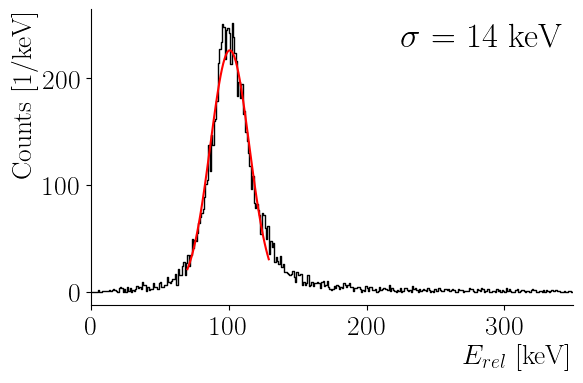

 FCN=114.768 FROM MIGRAD    STATUS=CONVERGED      67 CALLS          68 TOTAL
                     EDM=1.47301e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.26299e+02   3.50446e+00   1.35059e-02   5.81292e-06
   2  Mean         1.00722e+02   1.79441e-01   9.35046e-04   2.83325e-04
   3  Sigma        1.41435e+01   1.82885e-01   1.74100e-05   4.44690e-03


In [50]:
%matplotlib

distance = 35
doubleplane = 30
energy = 600
erel = 100
neutron = 1
physics = "inclxx"
scenario = "vacuum"  # no Sn in air -> No erel

basepath = "output/%s-%s/" % (physics.lower(), scenario)
basename = "%dm_%ddp_%dAMeV_%dkeV_%dn" % (distance, doubleplane, energy, erel, neutron)

file = rootpy.io.root_open(basepath + basename + ".reco.root", "read")
herel = file.Get(f"NeulandNeutronReconstructionMon/fhErel{neutron}")

xmin = 70
xmax = 130

fitresult = herel.Fit("gaus", "S", "", xmin, xmax)
print("Sigma", fitresult.GetParams()[2])

fun = fitresult.FittedFunction().GetFunction()
xs = np.arange(xmin, xmax, 1)
ys = [fun.Eval(x) for x in xs]

fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
ax = fig.add_subplot(111)
ax.set_xlim(0, 350)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylabel(r"Counts [1/keV]", horizontalalignment="right", y=1)
rplt.step(herel, axes=ax, color="black", label=r"Result")
ax.plot(xs, ys, color="red")
ax.text(
    0.98,
    0.9,
    fr"$\sigma$ = {round(fitresult.GetParams()[2])} keV",
    horizontalalignment="right",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=25,
)
fig.savefig(f"paper/erel-{neutron}n-{erel}.pdf", bbox_inches="tight")
display(fig)

Using matplotlib backend: agg
Sigma 28.409394815373933


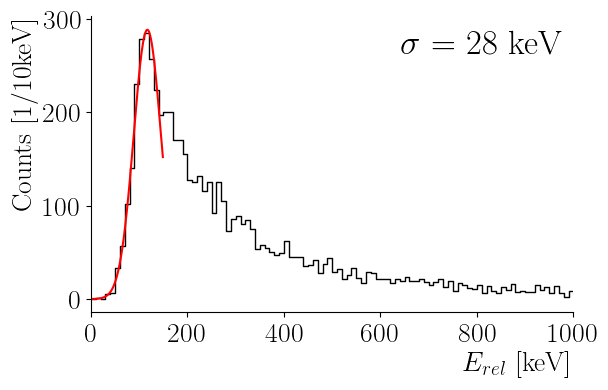

 FCN=12.3384 FROM MIGRAD    STATUS=CONVERGED      64 CALLS          65 TOTAL
                     EDM=2.48113e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.88714e+02   8.16064e+00   1.21139e-02  -2.97930e-05
   2  Mean         1.16854e+02   1.12256e+00   1.40355e-03  -5.00966e-04
   3  Sigma        2.84094e+01   8.03929e-01   1.15336e-05   7.15230e-02


In [51]:
%matplotlib

distance = 35
doubleplane = 30
energy = 600
erel = 100
neutron = 4
physics = "inclxx"
scenario = "vacuum"  # no Sn in air -> No erel

basepath = "output/%s-%s/" % (physics.lower(), scenario)
basename = "%dm_%ddp_%dAMeV_%dkeV_%dn" % (distance, doubleplane, energy, erel, neutron)

file = rootpy.io.root_open(basepath + basename + ".reco.root", "read")
herel = file.Get(f"NeulandNeutronReconstructionMon/fhErel{neutron}")
herel.rebin(10)

xmin = 0
xmax = 150

fitresult = herel.Fit("gaus", "S", "", xmin, xmax)
print("Sigma", fitresult.GetParams()[2])

fun = fitresult.FittedFunction().GetFunction()
xs = np.arange(xmin, xmax, 1)
ys = [fun.Eval(x) for x in xs]

fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
ax = fig.add_subplot(111)
ax.set_xlim(0, 1000)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylabel(r"Counts [1/10keV]", horizontalalignment="right", y=1)
rplt.step(herel, axes=ax, color="black", label=r"Result")
ax.plot(xs, ys, color="red")
ax.text(
    0.98,
    0.9,
    fr"$\sigma$ = {round(fitresult.GetParams()[2])} keV",
    horizontalalignment="right",
    verticalalignment="center",
    transform=ax.transAxes,
    fontsize=25,
)
fig.savefig(f"paper/erel-{neutron}n-{erel}.pdf", bbox_inches="tight")
display(fig)

## d) Resolution as a function of relative energy for both distances

In [11]:
def get_resolution(distance, doubleplane, energy, erel, neutron, physics, scenario):
    basepath = "output/%s-%s/" % (physics.lower(), scenario)
    basename = "%dm_%ddp_%dAMeV_%dkeV_%dn" % (distance, doubleplane, energy, erel, neutron)
    
    xmim = 0.7 * erel
    xmax = 1.3 * erel
    
    file = rootpy.io.root_open(basepath + basename + ".reco.root", "read")
    erel = file.NeulandNeutronReconstructionMon.fhErel1
    fitresult = erel.Fit("gaus", "S", "", xmin, xmax)
    return fitresult.GetParams()[2]

In [18]:
import pandas as pd
data = pd.DataFrame(
    [
        (
            distance,
            doubleplane,
            energy,
            erel,
            neutron,
            get_resolution(
                distance=distance,
                doubleplane=doubleplane,
                energy=energy,
                erel=erel,
                neutron=neutron,
                physics="inclxx",
                scenario="vacuum",
            ),
        )
        for distance in [15, 35]
        for doubleplane in [30]
        for energy in [600]
        for erel in [100, 500]
        for neutron in [1]
    ]
)
data.columns = ["distance", "doubleplane", "energy", "erel", "neutron", "sigma"]

 FCN=46.6354 FROM MIGRAD    STATUS=CONVERGED      88 CALLS          89 TOTAL
                     EDM=1.67825e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.96140e+01   1.98403e+00   4.68963e-03   8.79879e-05
   2  Mean         1.03779e+02   8.75863e-01   2.71546e-03   1.14795e-04
   3  Sigma        3.08159e+01   1.61111e+00   5.63523e-05   6.34736e-03
 FCN=610.975 FROM MIGRAD    STATUS=CONVERGED      81 CALLS          82 TOTAL
                     EDM=2.8693e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.32020e+01   6.81604e-01   5.98091e-03   8.39135e-06
   2  Mean         5.03618e+02   8.89719e-01   1.05198e-02   1.36424e-06
   3  Sigma        7.18108e+01   8

In [19]:
display(data)

,distance,doubleplane,energy,erel,neutron,sigma
0,15,30,600,100,1,30.815933
1,15,30,600,500,1,71.810775
2,35,30,600,100,1,14.143493
3,35,30,600,500,1,36.658983


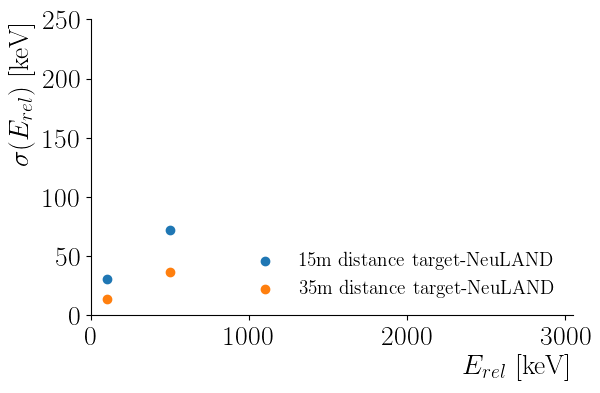

In [36]:
fig = plt.figure(figsize=(6.224, 6.224 / 1.618))
ax = fig.add_subplot(111)
ax.set_xlim(0, 3050)
ax.set_xlabel(r"$E_{rel}$ [keV]", horizontalalignment="right", x=1)
ax.set_ylim(0, 250)
ax.set_ylabel(r"$\sigma(E_{rel})$ [keV]", horizontalalignment="right", y=1)

for distance in [15, 35]:
    tmp = data.loc[data["distance"] == distance]
    ax.scatter(tmp["erel"].values, tmp["sigma"].values, label=f"{distance}m distance target-NeuLAND")

ax.legend(loc='lower right', prop={'size': 'x-small'})
fig.savefig("paper/sigma.pdf", bbox_inches="tight")
display(fig)